<a href="https://colab.research.google.com/github/Son0208/prac_class/blob/main/Sentimental_Analysis_Tweet_Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/sentiment-analysis-of-covid-19-related-tweets/overview

https://www.kaggle.com/sagarjiyani/toxic-comment-classifier

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Dense,Embedding, Input , Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers
from sklearn.metrics import  roc_auc_score

import warnings
warnings.simplefilter(action="ignore")

In [ ]:
!git clone https://github.com/Son0208/repository.git

In [17]:
train = pd.read_csv('repository/training.csv')
test = pd.read_csv('repository/validation.csv')

In [18]:
train = train[['ID','Tweet']].join(train.Labels.str.join("|").str.get_dummies())
train.rename(columns = {' ' : '10'}, inplace = True)  # train.columns = ['ID', 'Tweet', '10', '0','1','2','3','4','5','6','7','8','9']
train = train[['ID','Tweet','0','1','2','3','4','5','6','7','8','9','10']]

In [19]:
train.head()

,ID,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,1,1,0,0,0,0,0,0,0,0,1
1,2,BanMediaHouse whose is responsible for spreadi...,0,0,0,0,0,0,1,0,0,0,0
2,3,Im waiting for someone to say to me that all t...,0,0,0,1,1,0,0,0,0,0,1
3,4,He is a liar. Proven day night. Time again. Li...,0,0,0,0,0,0,1,0,0,0,0
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",0,0,0,0,0,0,0,0,1,0,0


In [20]:
test.head()

,ID,Tweet
0,5001,Forgot to a math test and I was failing but my...
1,5002,Corona effected came from Delhi in Bihar lakhi...
2,5003,Make CORONA END NA
3,5004,Imagine if the coronavirus pandemic was a big ...
4,5005,Howdy Ana. Where can I get married during the ...


In [21]:
train['Tweet'][0]

'NO JOKE I WILL HOP ON A PLANE RN! (Well after COVID19 lol)'

In [22]:
classes = ['0','1','2','3','4','5','6','7','8','9','10']
targets = train[classes].values

train_sentences = train['Tweet']
test_sentences = test['Tweet']

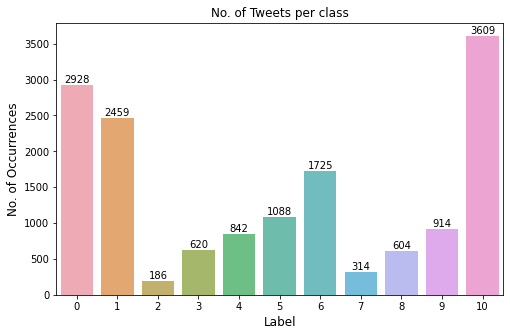

In [23]:
value_counts = train[classes].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(value_counts.index, value_counts.values, alpha=0.8)

plt.title("No. of Tweets per class" )
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

rects = ax.patches
labels = value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

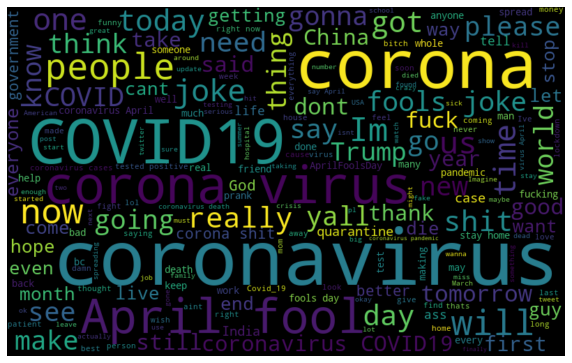

In [24]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in train['Tweet'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
max_features = 22000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_sentences))

tokenized_train = tokenizer.texts_to_sequences(train_sentences)
tokenized_test = tokenizer.texts_to_sequences(test_sentences)

In [26]:
maxlen = 200
X_train = pad_sequences(tokenized_train, maxlen = maxlen)
X_test = pad_sequences(tokenized_test, maxlen = maxlen)

In [27]:
embed_size = 128
maxlen = 200
max_features = 22000

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(11, activation="sigmoid")(x)

In [28]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
          optimizer= "adam",
          metrics=[f1])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2816000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [30]:
batch_size = 32
epochs = 15
results = model.fit(X_train, targets, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/15
125/125 [==============================] - 27s 48ms/step - loss: 0.5761 - f1: 0.5084 - val_loss: 0.4762 - val_f1: 0.5798
Epoch 2/15
125/125 [==============================] - 5s 39ms/step - loss: 0.4810 - f1: 0.5494 - val_loss: 0.4748 - val_f1: 0.5592
Epoch 3/15
125/125 [==============================] - 5s 40ms/step - loss: 0.4795 - f1: 0.5430 - val_loss: 0.4699 - val_f1: 0.5286
Epoch 4/15
125/125 [==============================] - 5s 39ms/step - loss: 0.4653 - f1: 0.5735 - val_loss: 0.4555 - val_f1: 0.5750
Epoch 5/15
125/125 [==============================] - 5s 39ms/step - loss: 0.4319 - f1: 0.6178 - val_loss: 0.4421 - val_f1: 0.5829
Epoch 6/15
125/125 [==============================] - 5s 39ms/step - loss: 0.3891 - f1: 0.6704 - val_loss: 0.4410 - val_f1: 0.5968
Epoch 7/15
125/125 [==============================] - 5s 40ms/step - loss: 0.3618 - f1: 0.7069 - val_loss: 0.4539 - val_f1: 0.6035
Epoch 8/15
125/125 [==============================] - 5s 39ms/step - loss: 0.3276 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


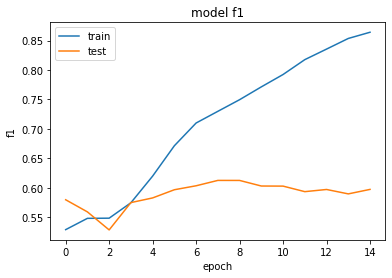

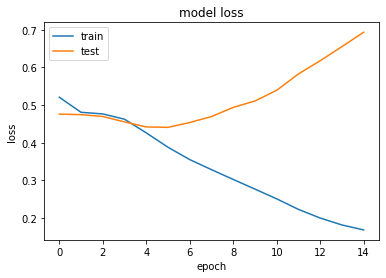

In [31]:
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['f1'])
plt.plot(results.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
prediction = model.predict(X_test)
prediction = (prediction>0.5)
prediction = pd.DataFrame(prediction)
prediction = prediction.applymap(lambda x: 1 if x else 0)
prediction

,0,1,2,3,4,5,6,7,8,9,10
0,1,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,1
2,1,1,0,0,0,0,0,0,0,1,1
3,1,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,0,0,0,0,1,1,1
2496,0,0,0,0,0,0,1,0,0,0,1
2497,1,0,0,0,0,0,0,0,0,1,1
2498,1,1,0,0,0,0,0,0,0,0,1


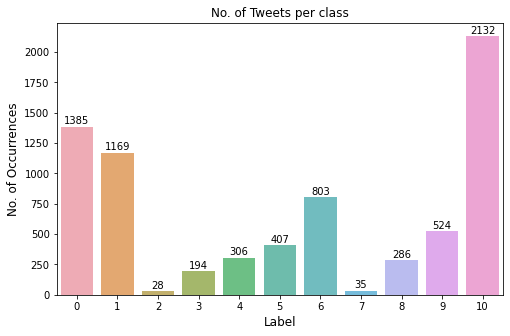

In [33]:
value_counts = prediction.sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(value_counts.index, value_counts.values, alpha=0.8)

plt.title("No. of Tweets per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

rects = ax.patches
labels = value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [34]:
prediction['Labels'] = 0

classes = list(map(int, classes))

for row in range(2500) :
    one_row = []
    for cat in classes :
        if int(prediction[row:row+1][cat].values) == 1 :
            one_row.append(cat)
    prediction.Labels[row] = ' '.join(map(str,one_row))

prediction=prediction[['Labels']]
prediction

,Labels
0,0 1 10
1,8 10
2,0 1 9 10
3,0 1
4,0 1 10
...,...
2495,8 9 10
2496,6 10
2497,0 9 10
2498,0 1 10


In [35]:
submission = pd.concat([test, prediction], axis=1).drop(['Tweet'],axis=1)
submission

,ID,Labels
0,5001,0 1 10
1,5002,8 10
2,5003,0 1 9 10
3,5004,0 1
4,5005,0 1 10
...,...,...
2495,7496,8 9 10
2496,7497,6 10
2497,7498,0 9 10
2498,7499,0 1 10


In [41]:
submission['Labels'].isnull().sum()

0

In [36]:
submission.dtypes

ID         int64
Labels    object
dtype: object

In [37]:
submission.to_csv('submission.csv', index=False)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

# prediction.set_index(test['ID'],inplace=True)
# prediction = prediction[prediction==1].stack().reset_index().drop(0,1)
# prediction = pd.concat([prediction,test[['ID']]]).reset_index()
# prediction = prediction.replace(np.nan, '', regex=True)
# prediction = prediction.assign(level_1=prediction.level_1.astype(str)).groupby('ID').level_1.apply(' '.join).reset_index()
# prediction = prediction.replace('.0', '', regex=True)
# prediction.rename(columns = {'level_1' : 'Labels'}, inplace = True)
# prediction